In [70]:
import sys
sys.path.append('../')
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from funcs.analysis.analysis import analysis
from scipy.optimize import minimize
import celerite
from celerite import terms
%matplotlib inline

wdir = '/disk1/hrb/python/'

def reader(n_subarray):
    return pd.read_csv(wdir+'data/merged/{}/r_band/with_ssa/lc_{}.csv'.format(obj,n_subarray), nrows=None, comment='#', index_col = ID, dtype = {'catalogue': np.uint8, 'mag': np.float32, 'magerr': np.float32, 'mjd': np.float64, ID: np.uint32})

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

In [71]:
obj = 'qsos'
ID  = 'uid'
band = 'r'
redshift_bool = True

# obj = 'calibStars'
# ID  = 'uid_s'
# band = 'r'
# redshift_bool = False

# Here we load the analysis class. This has various attibutes and methods outlined in /funcs/analysis.py
# Examples:
# Photometry is in dr.df

# Grouped statistics is in dr.grouped
# DR12 VAC properties are in dr.properties
dr = analysis(ID, obj)
dr.read_in(reader, redshift=redshift_bool)
dr.band = band
dr.group(keys = ['uid'],read_in=True, redshift=redshift_bool, survey = 'ztf')

/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [75]:
uids = dr.df_grouped.sort_values('n_tot', ascending=False).head(1).index

In [76]:
t, y, yerr = dr.df.loc[uids[0]].query('catalogue==11')[['mjd','mag', 'magerr']].values.T
# t -= t[0]
# y -= y.mean()

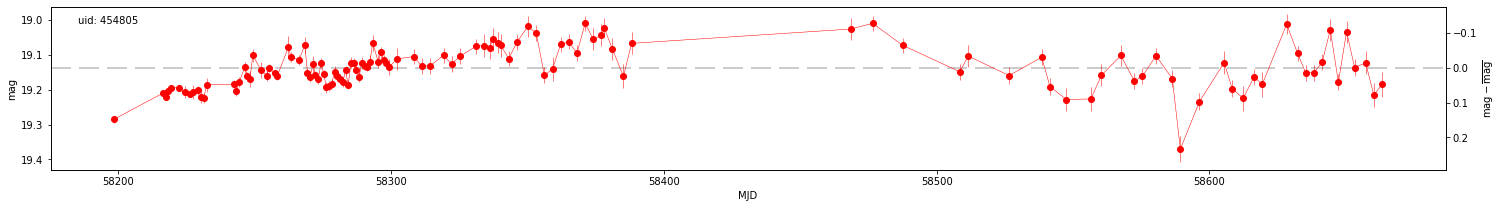

In [77]:
fig, ax = dr.plot_series(uids, survey=11)
fig.savefig('plot.pdf', bbox_inches='tight')

Initial log likelihood: -109.66977833731292
      fun: -218.29492577902164
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.13686838e-05, 1.70530258e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 11
     njev: 15
   status: 0
  success: True
        x: array([-5.47925199, -3.24634467])


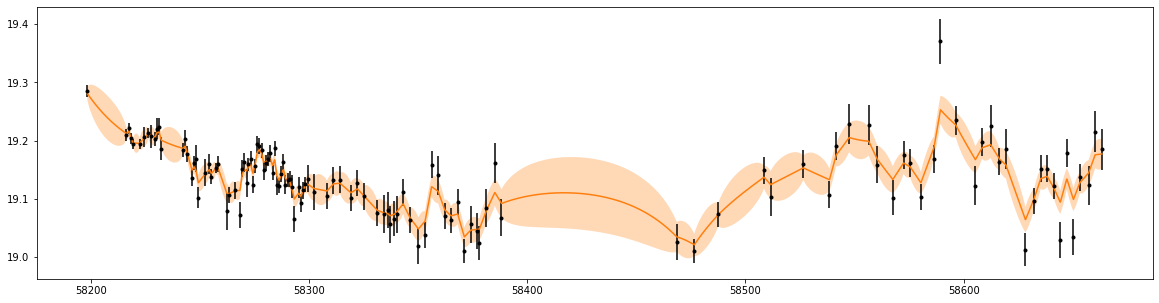

In [95]:
# Construct a real kernel
a = 1
c = 1
bounds = {'a':(-15,15), 'c':(-15,15)}
kernel = celerite.terms.RealTerm(log_a = np.log(a), log_c=np.log(c), bounds=bounds)
# kernel = freeze_parameter('a') # If we want to freeze one of the parameters

# Wrap the kernel
gp = celerite.GP(kernel, mean=y.mean())
gp.compute(t, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

fig, ax = plt.subplots(1,1, figsize=(20,5))

x = np.linspace(t[0], t[-1], 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

Initial log likelihood: 173.34671709684096
      fun: -210.70970264584844
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0002558 ,  0.00538876])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 11
     njev: 25
   status: 0
  success: True
        x: array([-3.63297224, -1.58696123])


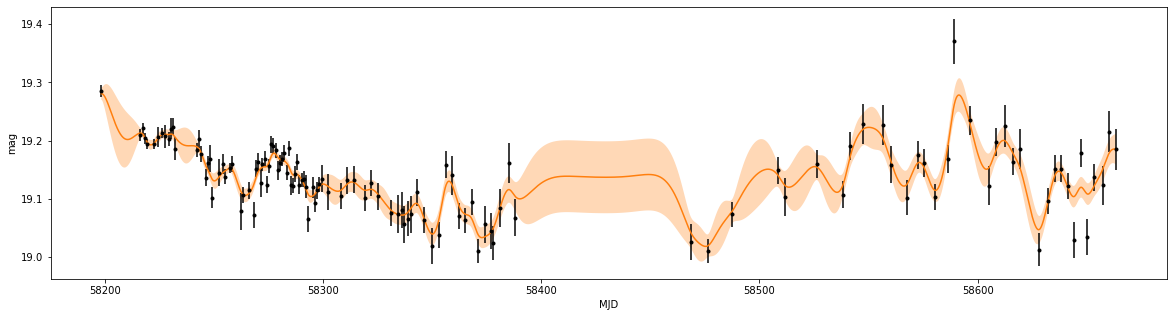

In [100]:
# Construct a simple harmonic oscilator kernel
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# Wrap the kernel
gp = celerite.GP(kernel, mean=y.mean())
gp.compute(t, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

fig, ax = plt.subplots(1,1, figsize=(20,5))

x = np.linspace(t[0], t[-1], 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
ax.set(ylabel='mag', xlabel='MJD')


fig.savefig('gaussian_process.pdf', bbox_inches='tight')